In [1]:
import numpy as np
import matplotlib.pyplot as plt

tau= 0.01
poissons_ratio = 0.20
E = 0.2 
Initial_stress = 200     #MPa
Inner_radius = 5
outer_radius = 20
Epsilon = 0              #Gauss point
delta_u = 1

n = 3
Shape_func = np.array([1/2*(1-Epsilon),1/2*(1+Epsilon)])
mu = E/(2*(1+poissons_ratio))
Lambda=poissons_ratio*E/((1-2*poissons_ratio)*(1+poissons_ratio))
volumetric_strain = -0.01




#displacement_1 = 1/3*tau*volumetric_strain*Inner_radius
C = np.array([[Lambda+2*mu,Lambda,Lambda],
              [Lambda,Lambda+2*mu,Lambda],
              [Lambda,Lambda,Lambda+2*mu]])



coordinate = np.linspace(Inner_radius,outer_radius,n+1)
                     # Zero matrix of order (n+1,n+1) for adding elemental stiffness


#Global_displacement = np.zeros((n+1,1))
  #Initial guess
# d = np.linspace(0,(1/3*tau*(-volumetric_strain)*coordinate[0]),n+1).reshape(n+1,1) #Initial guess
  
Global_displacement = np.zeros((n+1,1)) 
Global_displacement[0]= 1/3*tau*(-volumetric_strain)*coordinate[0]
print(Global_displacement)
Reduced_displacement = np.delete(Global_displacement,(0),axis=0)
Global_F_ext = np.zeros((n+1,1))


while np.linalg.norm(delta_u)>(0.005*np.linalg.norm(Reduced_displacement)):
    Global_K = np.zeros((n+1,n+1))  
    for i in range(len(coordinate)-1):  #Nodes-1 no of elements

        def element_routine(coordinate):
            Derivative_N = np.array([-1/2,1/2])
            Jacobian = Derivative_N@np.array([[coordinate[i]],
                                              [coordinate[i+1]]])
            J_inv = np.asscalar(1/Jacobian)

            B = np.array([[-1/2*J_inv,1/2*J_inv],
                          [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                          [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])

            B_T = np.transpose(B)
            Element_stiffness = 2*(B_T@(material_routine(Lambda,mu))@B)*Jacobian*((coordinate[i]+coordinate[i+1])/2)**2

            #External force calculation
            sigma_rr = 2*mu*J_inv*((-Global_displacement[i]+Global_displacement[i+1])/2)+Lambda*tau*volumetric_strain

            Fe = np.array([[-np.asscalar(sigma_rr)*coordinate[i]**2],
                           [np.asscalar(sigma_rr)*coordinate[i+1]**2]])
            #print(Fe)
            return Element_stiffness



        def material_routine(Lambda,mu):
            return C

        #Assignmnet matrix
        Ae = np.zeros((2,n+1))
        Ae[0,i]=1                                            # [0,n-1]=1 [1,n]=1
        Ae[1,i+1]  =1
        AeT = np.transpose(Ae)

        Ke = element_routine(coordinate)
        #Global stiffness matrix
        K=AeT@Ke@Ae                                          # Stiffness matrix  of each element after transformation
        Global_K = np.add(Global_K,K)                        # Global stiffnes matrix
    print(Global_K)
    K_red = np.delete(Global_K,(0),axis=0)
    K_red = np.delete(K_red,(0),axis=1)



        


    Global_F_ext = np.zeros((n+1,1))
    #Newton Raphson method


    G_matrix = Global_K@Global_displacement - Global_F_ext
   
    G_red = np.delete(G_matrix,(0),axis=0)
    delta_u = np.linalg.inv(K_red)@G_red
    Reduced_displacement = Reduced_displacement - delta_u

    Global_displacement = np.insert(Reduced_displacement,(0),(1/3*tau*(-volumetric_strain)*Inner_radius)).reshape(n+1,1)
    print(Global_displacement)



[[0.00016667]
 [0.        ]
 [0.        ]
 [0.        ]]
[[  2.36111111  -1.80555556   0.           0.        ]
 [ -1.80555556  10.27777778  -6.25         0.        ]
 [  0.          -6.25        21.38888889 -12.91666667]
 [  0.           0.         -12.91666667  16.25      ]]
[[1.66666667e-04]
 [4.44792838e-05]
 [2.49955629e-05]
 [1.98682680e-05]]
[[  2.36111111  -1.80555556   0.           0.        ]
 [ -1.80555556  10.27777778  -6.25         0.        ]
 [  0.          -6.25        21.38888889 -12.91666667]
 [  0.           0.         -12.91666667  16.25      ]]
[[1.66666667e-04]
 [4.44792838e-05]
 [2.49955629e-05]
 [1.98682680e-05]]


[1.66666667e-04 4.16666667e-05 1.85185185e-05 1.04166667e-05]


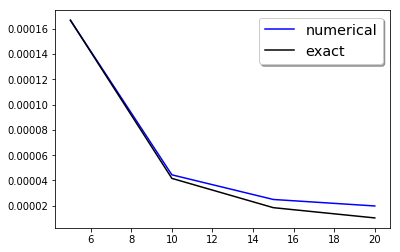

In [17]:
u_elastic = ((Inner_radius)**3*(-volumetric_strain)*tau)/(3*(coordinate)**2)
print(u_elastic)
fig,ax = plt.subplots()
ax.plot(coordinate,Global_displacement,'b',label='numerical')
ax.plot(coordinate,u_elastic,'k',label='exact')
ax.legend(loc='upper right', shadow=True, fontsize='x-large')